# About Stochastic

- What is: A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result.

# Importing data

In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf 
from datetime import date, timedelta
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [2]:
asset = 'AMZN'
end_date = date.today()
start_date = end_date - timedelta(365*20) # 20 years

end_date, start_date

(datetime.date(2024, 2, 2), datetime.date(2004, 2, 7))

In [3]:
df = yf.download(asset, start_date, end_date)

df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-02-09,2.337500,2.340000,2.285000,2.293000,2.293000,122922000
2004-02-10,2.292500,2.312500,2.275500,2.279500,2.279500,98980000
2004-02-11,2.293000,2.368000,2.277000,2.357000,2.357000,157634000
2004-02-12,2.346500,2.405000,2.335500,2.353000,2.353000,135144000
2004-02-13,2.364500,2.385000,2.312000,2.319000,2.319000,108634000
...,...,...,...,...,...,...
2024-01-26,158.419998,160.720001,157.910004,159.119995,159.119995,51047400
2024-01-29,159.339996,161.289993,158.899994,161.259995,161.259995,45270400
2024-01-30,160.699997,161.729996,158.490005,159.000000,159.000000,45207400


# Calculating stochastic
Setps:
- Calculate: %K = 100 * (Price today – lower price 14 days) / (higher price 14 days – low price 14 days)
- calculate: %D = %k moving average 3 days
- %K and %D going to be guide lines for buy and sell

In [5]:
# Higher and lower price last 14 days

df['Higher price'] = df['Adj Close'].rolling(window = 14).max()
df['Lower price'] = df['Adj Close'].rolling(window = 14).min()

df = df.dropna()

In [6]:
# %k
df['%k'] = (df['Adj Close'] - df['Lower price']) / (df['Higher price'] - df['Lower price']) * 100

# %D
df['%D'] = df['%k'].rolling(window = 3).mean()

df = df.dropna()

In [7]:
df

,Open,High,Low,Close,Adj Close,Volume,Higher price,Lower price,%k,%D
Date,,,,,,,,,,
2004-03-02,2.136500,2.174500,2.093000,2.100500,2.100500,139332000,2.357000,2.100500,0.000000,9.266957
2004-03-03,2.093000,2.169000,2.082500,2.158500,2.158500,192032000,2.353000,2.100500,22.970254,12.151911
2004-03-04,2.156000,2.223500,2.155000,2.219500,2.219500,147602000,2.319000,2.100500,54.462249,25.810834
2004-03-05,2.189500,2.241500,2.176500,2.204500,2.204500,128530000,2.276500,2.100500,59.090866,45.507789
2004-03-08,2.198000,2.253000,2.156500,2.175000,2.175000,132170000,2.258500,2.100500,47.151803,53.568306
...,...,...,...,...,...,...,...,...,...,...
2024-01-26,158.419998,160.720001,157.910004,159.119995,159.119995,51047400,159.119995,149.100006,100.000000,100.000000
2024-01-29,159.339996,161.289993,158.899994,161.259995,161.259995,45270400,161.259995,151.369995,100.000000,100.000000
2024-01-30,160.699997,161.729996,158.490005,159.000000,159.000000,45207400,161.259995,151.710007,76.335106,92.111702


<Axes: xlabel='Date'>

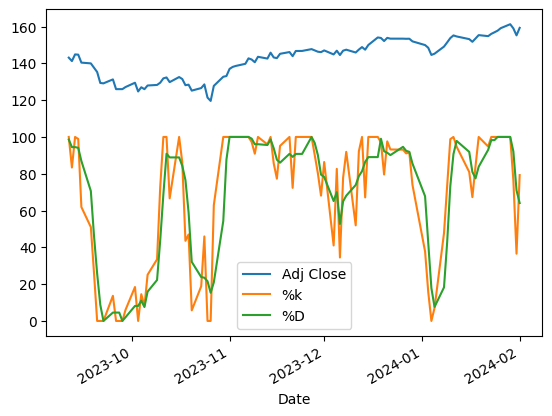

In [8]:
# Selected only 100 days just to see more clearly the chart
df[['Adj Close','%k', '%D']].tail(100).plot()

# Long position

- Buy = %k or %D cross above 20
- Sell = %k or %D cross above 80 or stop loss of x days

In [9]:
def long_position_dates(df, stop_loss_time):

    buy_dates = []
    sell_dates = []

    for i in range(1, len(df)): # Taking away the first element

        k_day_before = df.iloc[i-1]['%k']
        k_today = df.iloc[i]['%k']

        d_day_before = df.iloc[i-1]['%D']
        d_today = df.iloc[i]['%D']
        
        # This indicate that %k crossed above 20
        if ((k_day_before < 20) & (k_today >= 20)) | ((d_day_before < 20) & (d_today >= 20)):

            try: # This is for those cases that it is on te last element of df
                buy_dates.append(df.iloc[i+1].name) # buy next day

                for j in range(1, stop_loss_time+1): # Stop loss of x days or crossed above 80
                    
                    try:
                        new_k_day_before = df.iloc[i+j-1]['%k']
                        new_k_today = df.iloc[i+j]['%k']

                        new_d_day_before = df.iloc[i+j-1]['%D']
                        new_d_today = df.iloc[i+1]['%D']

                        if ((new_k_day_before < 80) & (new_k_today >= 80)) | ((new_d_day_before < 80) & (new_d_today >= 80)):
                            sell_dates.append(df.iloc[i+j+1].name) # sell next day
                            break
                            
                        elif j == stop_loss_time:
                            try:
                                sell_dates.append(df.iloc[i+j+1].name)
                            except:
                                sell_dates.append(df.iloc[-1].name) # this is for operations in the nearest x days
                    
                    except:
                        buy_dates.remove(df.iloc[i+1].name)

            except:
                'The last element error :('
                
    return [buy_dates, sell_dates]

In [10]:
lp_dates = long_position_dates(df, 30)

lp_buy_dates = lp_dates[0]
lp_sell_dates = lp_dates[1]

In [11]:
len(lp_buy_dates), len(lp_sell_dates)

(461, 461)

# Short position

- Sell = %k or %D cross below 80
- Buy = %k or %D cross below 20

In [12]:
def short_position_dates(df, stop_loss_time):

    buy_dates = []
    sell_dates = []

    for i in range(1, len(df)): # Taking away the first element

        k_day_before = df.iloc[i-1]['%k']
        k_today = df.iloc[i]['%k']

        d_day_before = df.iloc[i-1]['%D']
        d_today = df.iloc[i]['%D']
        
        # This indicate that %k crossed below 80
        if ((k_day_before > 80) & (k_today <= 80)) | ((d_day_before > 80) & (d_today <= 80)):

            try: # This is for those cases that it is on te last element of df

                sell_dates.append(df.iloc[i+1].name) # Sell next day

                for j in range(1, stop_loss_time+1): # Stop loss of x days or crossed below 20
                    
                    try:
                        new_k_day_before = df.iloc[i+j-1]['%k']
                        new_k_today = df.iloc[i+j]['%k']

                        new_d_day_before = df.iloc[i+j-1]['%D']
                        new_d_today = df.iloc[i+1]['%D']

                        if ((new_k_day_before > 20) & (new_k_today <= 20)) | ((new_d_day_before > 20) & (new_d_today <= 20)):
                            buy_dates.append(df.iloc[i+j+1].name) # buy next day
                            break
                            
                        elif j == stop_loss_time:
                            try:
                                buy_dates.append(df.iloc[i+j+1].name)
                            except:
                                buy_dates.append(df.iloc[-1].name) # this is for operations in the nearest x days
                    
                    except:
                        sell_dates.remove(df.iloc[i+1].name)
                        
            except:
                'The last element error :('

    return [buy_dates, sell_dates]

In [13]:
sp_dates = short_position_dates(df, 30)

sp_buy_dates = sp_dates[0]
sp_sell_dates = sp_dates[1]

In [14]:
len(sp_buy_dates), len(sp_sell_dates)

(560, 560)

# Comparison with buy and hold

In [15]:
buy_n_hold_return = ((df.iloc[-1]['Adj Close'] - df.iloc[0]['Adj Close']) / df.iloc[0]['Adj Close']) * 100
buy_n_hold_return

7482.955995230948

In [16]:
def find_returns(df, b_dates, s_dates):

    operation_returns = []

    for i in range(len(b_dates)):
        
        buy_price = df.loc[b_dates[i]]['Adj Close']
        sell_price = df.loc[s_dates[i]]['Adj Close']

        operation_return = (sell_price - buy_price) / buy_price

        operation_returns.append(operation_return)
    
    return operation_returns

In [17]:
lp_return = find_returns(df, lp_buy_dates, lp_sell_dates)
sp_return = find_returns(df,sp_buy_dates, sp_sell_dates)

- Positives and negative returns

In [18]:
lp_win_returns = []
lp_lost_returns = []

for i in lp_return:
    if i > 0: lp_win_returns.append(i)
    if i < 0: lp_lost_returns.append(i)

In [19]:
sp_win_returns = []
sp_lost_returns = []

for i in sp_return:
    if i > 0: sp_win_returns.append(i)
    if i < 0: sp_lost_returns.append(i)

In [20]:
lp_perc_win = len(lp_win_returns) / len(lp_return) * 100
lp_perc_lost = len(lp_lost_returns) / len(lp_return) * 100

print(f'Long position winning trades: {round(lp_perc_win,2)}%')
print(f'Long position losing trades: {round(lp_perc_lost,2)}%')

Long position winning trades: 68.11%
Long position losing trades: 31.89%


In [21]:
sp_perc_win = len(sp_win_returns) / len(sp_return) * 100
sp_perc_lost = len(sp_lost_returns) / len(sp_return) * 100

print(f'Short position winning trades: {round(sp_perc_win,2)}%')
print(f'Short position losing trades: {round(sp_perc_lost,2)}%')

Short position winning trades: 56.07%
Short position losing trades: 43.75%


In [22]:
lp_average_win = np.mean(lp_win_returns)
lp_average_lost = np.mean(lp_lost_returns)

print(f'Average of long position winning trades: {round(lp_average_win,3)}% per trade')
print(f'Average of long position losing trades: {round(lp_average_lost,3)}% per trade')

Average of long position winning trades: 0.042% per trade
Average of long position losing trades: -0.049% per trade


In [23]:
sp_average_win = np.mean(sp_win_returns)
sp_average_lost = np.mean(sp_lost_returns)

print(f'Average of short position winning trades: {round(sp_average_win,3)}% per trade')
print(f'Average of short position losing trades: {round(sp_average_lost,3)}% per trade')

Average of short position winning trades: 0.032% per trade
Average of short position losing trades: -0.064% per trade


- Cumulative return

In [24]:
lp_cumulative_return = ((np.cumprod(1 + np.array(lp_return)) - 1) * 100)[-1]
lp_cumulative_return

13494.15560870137

In [25]:
sp_cumulative_return = ((np.cumprod(1 + np.array(sp_return)) - 1) * 100)[-1]
sp_cumulative_return

-99.91972705762406

In [26]:
lp_sp_cumulative_return = np.mean([lp_cumulative_return, sp_cumulative_return])
lp_sp_cumulative_return

6697.117940821873

- Stochastic vs Buy and Hold

In [27]:
print(f'Buy n hold return: {round(buy_n_hold_return,2)}%')
print(f'Stochastic model return: {round(lp_sp_cumulative_return,2)}%')

Buy n hold return: 7482.96%
Stochastic model return: 6697.12%
